# 03 — Category Detection with Stratified K-Fold Cross Validation

Goal: 
Train and evaluate multiple classical ML models for **news category classification** using:
- TF-IDF feature extraction
- **StratifiedKFold (k=5)**
- Metrics: accuracy, precision, recall, F1
- Report **mean ± std** across folds (mentor requirement)

Output:
A final table: **Model comparison (mean ± std)**.

In [23]:
# Used Libraries

import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

In [9]:
# Helper methods

def print_dataset(text, df):
    print("\n" + text + ":")
    display(df.head())

def read_dataset(path):
    return pd.read_csv(path)

### Constants

In [10]:
RANDOM_STATE = 42
N_SPLITS = 5

DATA_PATH = "../data/preprocessed_kosovo_news.csv"
TEXT_COL = "text"                                  
CATEGORY_COL = "category"
MODEL_COMPARISONS = [] 

### Read dataset

In [11]:
df = read_dataset(DATA_PATH)
df.head()

,content,title,category,text
0,Kur Beatrice Borromeo u martua me Pierre Casir...,As Kate as Meghan; ja cila është princesha më ...,Fun;Argëtim,as kate as meghan; ja cila është princesha më ...
1,Gjatë kontrollit të automjetit zyrtarët polico...,"I kapen 10 kg substanca narkotike në BMW X5, a...",Lajme;Nacionale,"i kapen 10 kg substanca narkotike në bmw x5, a..."
2,Enca Haxhia njihet si një ndër këngëtaret më s...,Enca e quan jetë pushimin në plazh me poza në ...,Entertainment,enca e quan jetë pushimin në plazh me poza në ...
3,Gurët në veshka janë depozitime minerale që fo...,Gurët në veshka – Kurat natyrale dhe si t’i pë...,Lifestyle;Shëndeti,gurët në veshka – kurat natyrale dhe si t’i pë...
4,Në vendim thuhet se Zyra e Prokurorit të Speci...,Trupi gjykues ua vazhdon paraburgimin Nasim Ha...,Lajme;Nacionale,trupi gjykues ua vazhdon paraburgimin nasim ha...


## Label Engineering

### Primary Category
The dataset may contain multiple categories separated by `;`.
For standard multi-class classification, we define a single target label per sample.
We use a deterministic rule to extract a **primary category**.

In [12]:
def extract_primary_category(cat: str) -> str:
    # Split by ';', remove empty and 'nan' tokens, then pick one.
    parts = [p.strip() for p in cat.split(";") if p.strip() and p.strip().lower() != "nan"]
    if not parts:
        return np.nan
    
    # use the LAST category
    return parts[-1]

df["primary_category"] = df[CATEGORY_COL].apply(extract_primary_category)
df = df.dropna(subset=["primary_category"]).copy()

df["primary_category"].value_counts().head(20)

primary_category
Lajme            432740
Kosovë           154477
Sport            122003
Ndërkombëtare     81791
Maqedoni          60971
Shkurt            47810
Yjet              43041
Showbiz           40595
Shqiperi          34774
Bota              31586
Shqipëri          30341
Magazina          28549
Ekonomi           25493
CultBiz           20675
Politikë          17395
Shëndetësi        13431
Indeks+           12218
Kuriozitete       10963
Opinione          10656
Muzikë            10604
Name: count, dtype: int64

### Filtering rare categories
Rare categories were filtered to ensure stable stratified cross-validation and reliable metric estimation.

In [13]:
MIN_SAMPLES_PER_CLASS = 50  # tune (e.g., 20/50/100)
counts = df["primary_category"].value_counts()
keep = counts[counts >= MIN_SAMPLES_PER_CLASS].index
df = df[df["primary_category"].isin(keep)].copy()

before = len(counts)
after = len(keep)

print(f"Classes before filtering: {before}")
print(f"Classes after filtering (>= {MIN_SAMPLES_PER_CLASS} samples): {after}")
print(f"Removed {before - after} rare classes")

df["primary_category"].value_counts().describe()

Classes before filtering: 252
Classes after filtering (>= 50 samples): 181
Removed 71 rare classes


count       181.000000
mean       8036.784530
std       36322.686434
min          51.000000
25%         162.000000
50%         722.000000
75%        2827.000000
max      432740.000000
Name: count, dtype: float64

## Baseline models and results
In this section, we evaluate several classical machine learning models for category classification.
All models use the same TF-IDF feature representation to ensure a fair comparison.

**Label Encoding and Class Overview**

We convert the primary category labels into numeric form using label encoding, as required by classical machine learning models.
This step defines the prediction target and establishes a fixed mapping between category names and class indices.

We additionally report the total number of categories and example labels to highlight the scale and complexity of the classification task.

In [14]:
le = LabelEncoder()
y = le.fit_transform(df["primary_category"])
X = df["text"]

NUM_CLASSES = len(le.classes_)
print("Classes:", NUM_CLASSES)
print("Example classes:", le.classes_[:15])

Classes: 181
Example classes: ['Afrika' 'Amerika' 'Analiza' 'Analizë' 'Aplikacione' 'Argëtim' 'Arsim'
 'Arte' 'Atletikë' 'Australia' 'Auto' 'AutoMoto' 'AutoTech' 'Azia'
 'Ballina']


**Baseline Models**
- We evaluate multiple baseline classifiers commonly used in text classification tasks.
These models provide strong and interpretable baselines before applying more complex approaches.

In [15]:
MODELS = {
    "MultinomialNB": MultinomialNB(),
    "LinearSVC": LinearSVC(),
    "SGD_LogReg": SGDClassifier(
        loss="log_loss",
        alpha=1e-5,
        max_iter=1000,
        tol=1e-3,
        random_state=RANDOM_STATE
    )
}

**Reusable Evaluation Framework (K-Fold)**

- In this section, we define a reusable evaluation setup for all baseline models.
- We standardize the configuration (random seed, number of folds, TF-IDF settings) to ensure fair and comparable results.
- Helper functions are provided to:
  - build the TF-IDF + classifier pipeline,
  - run Stratified K-Fold cross-validation,
  - collect results into a comparison table (leaderboard),
  - and optionally produce a confusion matrix for error analysis.

In [16]:
# =========================
# K-FOLD MODEL EVALUATION
# =========================

# -------------------------
# CONFIG (SAFE FOR MAC)
# -------------------------
RANDOM_STATE = 42
N_SPLITS = 5
N_JOBS = 1
MAX_FEATURES = 10000

from joblib import Memory
memory = Memory(location="./.sk_cache", verbose=0)

# -------------------------
# CV + METRICS
# -------------------------
cv = StratifiedKFold(
    n_splits=N_SPLITS,
    shuffle=True,
    random_state=RANDOM_STATE
)

SCORING = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, average="weighted", zero_division=0),
    "recall": make_scorer(recall_score, average="weighted", zero_division=0),
    "f1": make_scorer(f1_score, average="weighted", zero_division=0),
}

# -------------------------
# PIPELINE
# -------------------------
def build_pipeline(model):
    return Pipeline(
        [
            ("tfidf", TfidfVectorizer(
                max_features=MAX_FEATURES,
                ngram_range=(1, 1),  # start unigram (fast)
                # Then if it’s fast enough, switch to: ngram_range=(1,2)
                min_df=2
            )),
            ("clf", model)
        ],
        memory=memory
    )

# -------------------------
# STORAGE
# -------------------------
MODEL_COMPARISONS = []

# -------------------------
# RUN ONE MODEL AT A TIME
# -------------------------
def run_model(model_name):
    print(f"\nRunning model: {model_name} ...")

    pipeline = build_pipeline(MODELS[model_name])

    scores = cross_validate(
        pipeline,
        X, y,
        cv=cv,
        scoring=SCORING,
        n_jobs=N_JOBS,
        return_train_score=False
    )

    row = {
        "model": model_name,
        "accuracy_mean": float(np.mean(scores["test_accuracy"])),
        "accuracy_std": float(np.std(scores["test_accuracy"])),
        "precision_mean": float(np.mean(scores["test_precision"])),
        "precision_std": float(np.std(scores["test_precision"])),
        "recall_mean": float(np.mean(scores["test_recall"])),
        "recall_std": float(np.std(scores["test_recall"])),
        "f1_mean": float(np.mean(scores["test_f1"])),
        "f1_std": float(np.std(scores["test_f1"]))
    }

    MODEL_COMPARISONS.append(row)

    # show result as markdown table
    df_one = pd.DataFrame([row])
    display(Markdown(df_one.to_markdown(index=False)))

    return row

# -------------------------
# FINAL LEADERBOARD
# -------------------------
def show_leaderboard():
    if not MODEL_COMPARISONS:
        print("No models evaluated yet.")
        return

    dataframe = (
        pd.DataFrame(MODEL_COMPARISONS)
        .sort_values("f1_mean", ascending=False)
        .reset_index(drop=True)
    )
    display(dataframe)

-- Blerona - split 20k test

In [34]:
from sklearn.model_selection import train_test_split

X_small, _, y_small, _ = train_test_split(
    X,
    y,
    train_size=20000,
    stratify=y,
    random_state=RANDOM_STATE
)

scores = cross_validate(build_pipeline(MODELS["SGD_LogReg"]), X_small, y_small, cv=cv, scoring=SCORING, n_jobs=1)

/Users/fatlumberisha/Blerona/Sarcasm-Detection-Albanian-News-Dataset/.venv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


### Multinomial Naive Bayes

In [17]:
run_model("MultinomialNB")


Running model: MultinomialNB ...


| model         |   accuracy_mean |   accuracy_std |   precision_mean |   precision_std |   recall_mean |   recall_std |   f1_mean |      f1_std |
|:--------------|----------------:|---------------:|-----------------:|----------------:|--------------:|-------------:|----------:|------------:|
| MultinomialNB |        0.558242 |     0.00103444 |         0.546229 |      0.00116057 |      0.558242 |   0.00103444 |  0.527333 | 0.000977519 |

{'model': 'MultinomialNB',
 'accuracy_mean': 0.5582418685242452,
 'accuracy_std': 0.0010344399598150819,
 'precision_mean': 0.5462288590652654,
 'precision_std': 0.0011605653252616003,
 'recall_mean': 0.5582418685242452,
 'recall_std': 0.0010344399598150819,
 'f1_mean': 0.5273326366995609,
 'f1_std': 0.0009775194607017264}

### Linear SVM (LinearSVC)

In [18]:
run_model("LinearSVC")


Running model: LinearSVC ...


| model     |   accuracy_mean |   accuracy_std |   precision_mean |   precision_std |   recall_mean |   recall_std |   f1_mean |      f1_std |
|:----------|----------------:|---------------:|-----------------:|----------------:|--------------:|-------------:|----------:|------------:|
| LinearSVC |        0.722571 |    0.000709294 |         0.698319 |      0.00105343 |      0.722571 |  0.000709294 |  0.698514 | 0.000834896 |

{'model': 'LinearSVC',
 'accuracy_mean': 0.7225705280705432,
 'accuracy_std': 0.0007092939444431252,
 'precision_mean': 0.6983186938238608,
 'precision_std': 0.0010534269466726221,
 'recall_mean': 0.7225705280705432,
 'recall_std': 0.0007092939444431252,
 'f1_mean': 0.698513733104177,
 'f1_std': 0.0008348964140238559}

### Logistic Regression (SGD)

In [19]:
run_model("SGD_LogReg")


Running model: SGD_LogReg ...


| model      |   accuracy_mean |   accuracy_std |   precision_mean |   precision_std |   recall_mean |   recall_std |   f1_mean |      f1_std |
|:-----------|----------------:|---------------:|-----------------:|----------------:|--------------:|-------------:|----------:|------------:|
| SGD_LogReg |        0.657426 |    0.000619284 |         0.625647 |      0.00280034 |      0.657426 |  0.000619284 |  0.605263 | 0.000770396 |

{'model': 'SGD_LogReg',
 'accuracy_mean': 0.6574260060856839,
 'accuracy_std': 0.0006192836748570889,
 'precision_mean': 0.6256474522803078,
 'precision_std': 0.002800343621386601,
 'recall_mean': 0.6574260060856839,
 'recall_std': 0.0006192836748570889,
 'f1_mean': 0.6052632645465195,
 'f1_std': 0.0007703963836454752}

## Results summary
The table above summarizes the cross-validated performance of all baseline models.
LinearSVC achieves the highest overall performance in terms of weighted F1-score and accuracy, indicating stronger discrimination across categories.
Multinomial Naive Bayes performs worst, which is expected given the large number of classes and sparse feature space.

In [20]:
show_leaderboard()

,model,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
0,LinearSVC,0.722571,0.000709,0.698319,0.001053,0.722571,0.000709,0.698514,0.000835
1,SGD_LogReg,0.657426,0.000619,0.625647,0.002800,0.657426,0.000619,0.605263,0.000770
2,MultinomialNB,0.558242,0.001034,0.546229,0.001161,0.558242,0.001034,0.527333,0.000978


In [ ]:
def show_leaderboard():
    if not MODEL_COMPARISONS:
        print("No models evaluated yet.")
        return

    dataframe = (
        pd.DataFrame(MODEL_COMPARISONS)
        .sort_values("f1_mean", ascending=False)
        .reset_index(drop=True)
    )

    # Keep only key metrics
    main_metrics = dataframe[
        ["model", "f1_mean", "accuracy_mean", "precision_mean", "recall_mean"]
    ]

    display(main_metrics)

## Error Analysis

To better understand the remaining classification errors, we analyze the confusion matrix of the best-performing model.

### Confusion Matrix (Top-10 classes)

In [24]:
def evaluate_classifier(
    y_true,
    y_pred,
    label_encoder,
    title="Model",
    normalize="true",
    top_n=20,
):
    """
    Reusable evaluation:
    - Classification report (with zero_division=0)
    - Confusion matrix (optionally normalized)
    - Plot only top_n most frequent classes for readability
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # class names
    class_names = label_encoder.classes_
    labels_all = np.arange(len(class_names))

    # pick top_n classes by frequency in y_true
    counts = np.bincount(y_true, minlength=len(class_names))
    top_idx = np.argsort(counts)[::-1][:top_n]
    top_idx = np.sort(top_idx)  # keep matrix ordered

    # report (full, for all classes)
    print(f"\n=== {title} | Classification report (weighted) ===")
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=class_names,
            zero_division=0
        )
    )

    # confusion matrix (top_n only, readable)
    cm = confusion_matrix(
        y_true,
        y_pred,
        labels=top_idx,
        normalize=normalize
    )

    disp = ConfusionMatrixDisplay(cm, display_labels=class_names[top_idx])

    plt.figure(figsize=(12, 10))
    disp.plot(
        xticks_rotation=90,
        values_format=".2f" if normalize else "d",
        cmap="Blues"
    )
    plt.title(f"{title} | Confusion matrix (top {top_n})")
    plt.tight_layout()
    plt.show()


=== LinearSVC | Classification report (weighted) ===
                precision    recall  f1-score   support

        Afrika       0.55      0.19      0.28       220
       Amerika       0.71      0.67      0.69      2495
       Analiza       0.23      0.12      0.16       217
       Analizë       0.30      0.02      0.03       163
   Aplikacione       0.55      0.53      0.54      1935
       Argëtim       0.56      0.07      0.12        76
         Arsim       0.50      0.29      0.37      3536
          Arte       0.11      0.03      0.05       544
      Atletikë       0.54      0.24      0.33       127
     Australia       0.74      0.24      0.36       110
          Auto       0.64      0.70      0.67      4188
      AutoMoto       0.52      0.21      0.30        81
      AutoTech       0.00      0.00      0.00       414
          Azia       0.59      0.44      0.50      1183
       Ballina       0.00      0.00      0.00       122
       Ballkan       0.54      0.23      0.32    

<Figure size 1200x1000 with 0 Axes>

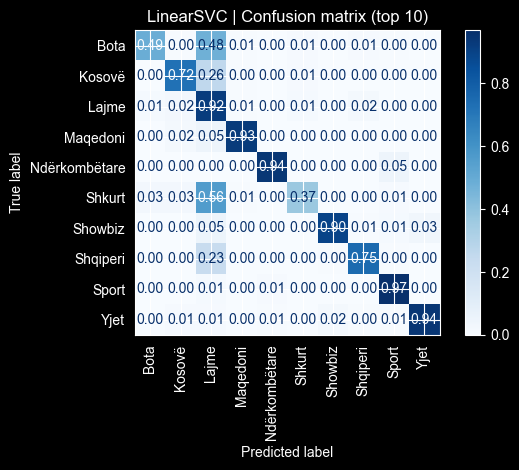

In [25]:
from sklearn.model_selection import cross_val_predict

# 1) Build pipeline for the best model
pipeline = build_pipeline(MODELS["LinearSVC"])

# 2) Get cross-validated predictions (no data leakage)
y_pred = cross_val_predict(
    pipeline,
    X,
    y,
    cv=cv,
    n_jobs=N_JOBS
)

# 3) Run error analysis
evaluate_classifier(
    y_true=y,
    y_pred=y_pred,
    label_encoder=le,
    title="LinearSVC",
    normalize="true",
    top_n=10
)

### Most Confused Categories